# Preliminaries

Names: Max Hammermann, Gerrit Gerhartz

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix
from scipy.sparse import find
from scipy.sparse import coo_matrix
from scipy.sparse import linalg

# 1. Constructing the Matrix X

One can design a function that constructs the projection matrix $X$.

In [2]:
def construct_X(M, alphas, Np=None):

    ## initial steps
    # parameters of the angle array
    N0 = len(alphas) 
    # calculate proposal for Np, if None is given
    if Np == None:
        Np = np.ceil(np.sqrt(2)*M).astype(int)
    # create dummy matrix to save grids for different angles
    C = np.zeros((N0, 2, M**2))
    

    ## produce a meshgrid
    c = np.mgrid[-M/2 + 0.5 : M/2, -M/2 + 0.5 : M/2]
    # start numeration at top left
    c[:] = c[0], c[1] 
    # create several meshgrids for different angles and save them to dummy array
    C[:] = c.reshape((2, M**2)) 
    

    ## compute normal vector n and distance s0 between middle of sensor and position of 0th sensor
    # translate angles from grad into rad
    alphas = np.deg2rad(alphas)
    # compute normal vector using transformation rule in polar coordinates
    n = np.array([-np.sin(alphas), np.cos(alphas)])
    # compute distance relative to 0th pixel
    s0 = (Np-1)/2
    
    ## compute position where beam through this pixel hits the sensor for different angels according to exercise sheet
    # scalar product can be vectorized by componentwise multiplication with each component of n and then summing over the two contributions
    p = np.multiply(C[:, 0, :].T, n[0]).T + np.multiply(C[:, 1, :].T, n[1]).T + s0
    # compute steps between sensors
    step = 2*s0 / (Np-1)
    
    # divide position into sensor districts
    detect = p/step
    
    ## construct relevant detector indices
    # find out about detector hit lower/upper by the beam
    detect_indices_low = detect - detect % 1
    detect_indices_up = detect_indices_low + 1
    # put detect indices into an array
    detect_indices = np.concatenate((detect_indices_low, detect_indices_up), axis = 1)
    
    # use equation from sheet to calculate the index i with different angles (index i0)
    for i0 in range(N0):
        detect_indices[i0, :] = detect_indices[i0, :] + Np * i0
    
    # calulate weight for each pixel and save it into array
    weight_1 = 1 - detect % 1
    weight_2 = detect % 1
    data = np.concatenate((weight_1, weight_2), axis = 1).flatten()
    
    ## create data for the scipy
    # define indices i and j only where the weight is unequal to zero (input for the coo_matrix-function)
    i_indices = detect_indices.flatten()[data != 0]
    
    # define j_indices with the corresponding structure we used above for the
    # weight (called data) and the i_indices
    j_indices = np.zeros((N0, 2, M**2))
    # origin in top left corner
    j_indices[:, :] = np.arange(M**2)
    # provide necessary indices
    j_indices = j_indices.flatten()[data!=0]
    
    # restrict data where it is not 0 (data input for coo_matrix-function)
    data = data[data != 0]
    
    # apply coo_matrix-function to generate sparse matrix
    X = coo_matrix((data, (i_indices, j_indices)), shape=(Np * N0, M**2), dtype = np.float32)
    return X

One can check whether this function works by testing it with the data set on the sheet:

In [3]:
X_example = np.load('hs_tomography/hs_tomography/X_example.npy')

In [4]:
X_ij = construct_X(10, np.array([-33, 1, 42]), 15)
# convert sparse matrix into a numpy array for visualization
X_ij_array = X_ij.toarray()

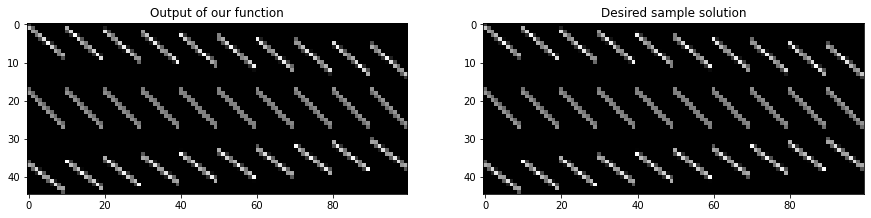

In [5]:
plt.figure(figsize=(15,6))
plt.gray()
plt.subplot(1, 2, 1)
plt.title('Output of our function')
plt.imshow(X_ij_array)
plt.subplot(1, 2, 2)
plt.title('Desired sample solution')
plt.imshow(X_example)

One can see that both outputs are optically quite similar. Furthermore, one can check how big the overlap in fact is (one must therefore remember that the array data types should be the same in both cases to avoid truncation differences):

In [6]:
print(f'Pixels where outputs differ: {np.sum(X_ij != X_example)}')

Pixels where outputs differ: 0


Apparently, our implementation works correctly on the example set.

# 2. Recovering the image

First of all, one can load the needed data from the given directory:

In [7]:
alphas_77 = np.load('hs_tomography/hs_tomography/alphas_77.npy')
alphas_195 = np.load('hs_tomography/hs_tomography/alphas_195.npy')
y_77 = np.load('hs_tomography/hs_tomography/y_77.npy')
y_195 = np.load('hs_tomography/hs_tomography/y_195.npy')

Using the information on the sheet to construct the image with lower resolution ($M=77$):

In [8]:
X = construct_X(77, alphas_77, 109)
# convert coo-format of X to csc-matrix for solving the linear system
X_csc = X.tocsc()

One can now find out about the sparsity of $X$:

In [9]:
_, _, vals = find(X)
print(f'Sparsity of X (number of values different from zero): {len(vals)}')
print(f'Fraction of numbers that are different from zero: {len(vals)/ (np.shape(X)[0]*np.shape(X)[1]):.4f}')

Sparsity of X (number of values different from zero): 1066978
Fraction of numbers that are different from zero: 0.0183


One can see that only 1,8% of the numbers in the matrix $X$ are different from 0.

Get $\beta$ as a result of the linear equation system.

In [10]:
beta = linalg.lsqr(X_csc, y_77, atol=1e-5, btol=1e-5)

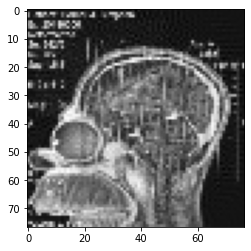

In [11]:
# reshape beta in order to get the absorption profile mu
mu = np.reshape(beta[0], (77, 77))
plt.imshow(mu)

These results are even with high tolerance not that convincing. Using the information on the sheet to construct the image with a higher resolution ($M=195$):

In [12]:
X = construct_X(195, alphas_195, 275)
X_csc = X.tocsc()

One can also here report the sparsity of $X$:

In [13]:
_, _, vals = find(X)
print(f'Sparsity of X (number of values different from zero): {len(vals)}')
print(f'Fraction of numbers that are different from zero: {len(vals)/ (np.shape(X)[0]*np.shape(X)[1]):.4f}')

Sparsity of X (number of values different from zero): 13535953
Fraction of numbers that are different from zero: 0.0072


We chose the tolerance with 1e-6, because smaller tolerances became computationally infeasible. However, the results are already quite convincing:

In [14]:
beta = linalg.lsqr(X_csc, y_195, atol=1e-6, btol=1e-6)

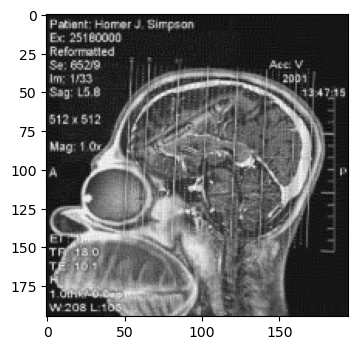

In [15]:
# reshape beta in order to get the absorption profile mu
mu = np.reshape(beta[0], (195, 195))
plt.figure(dpi=100)
plt.imshow(mu)

From this picture one can see that the cause for Homer's headache is probably the pencil that is stuck in his head.

# 3. Minimizing the radiation dose

One can now try to reduce the radiation dose by leaving out the measurements of some projections. In this exercise, only the $M=195$-picture is considered to still be able to make propositions about the quality in comparison to the above version.

In [16]:
def reduce_y_alpha(y, alphas_orig, mask, Np):
    n_i0 = len(alphas_orig)
    s = y.reshape((n_i0, Np))
    s_new = s[mask==1]
    y_new = s_new.flatten()
    alphas_new = alphas_orig[mask==1]
    return y_new, alphas_new

In [17]:
def create_mask(i, length):
    mask = np.zeros(length)
    mask[::i] = 1
    return mask

One can now try out, how the picture quality behaves, when taking only a subset of the projection angles into account. Therefore, one can take every second, third (and so on) projection angle and the data that comes with this.

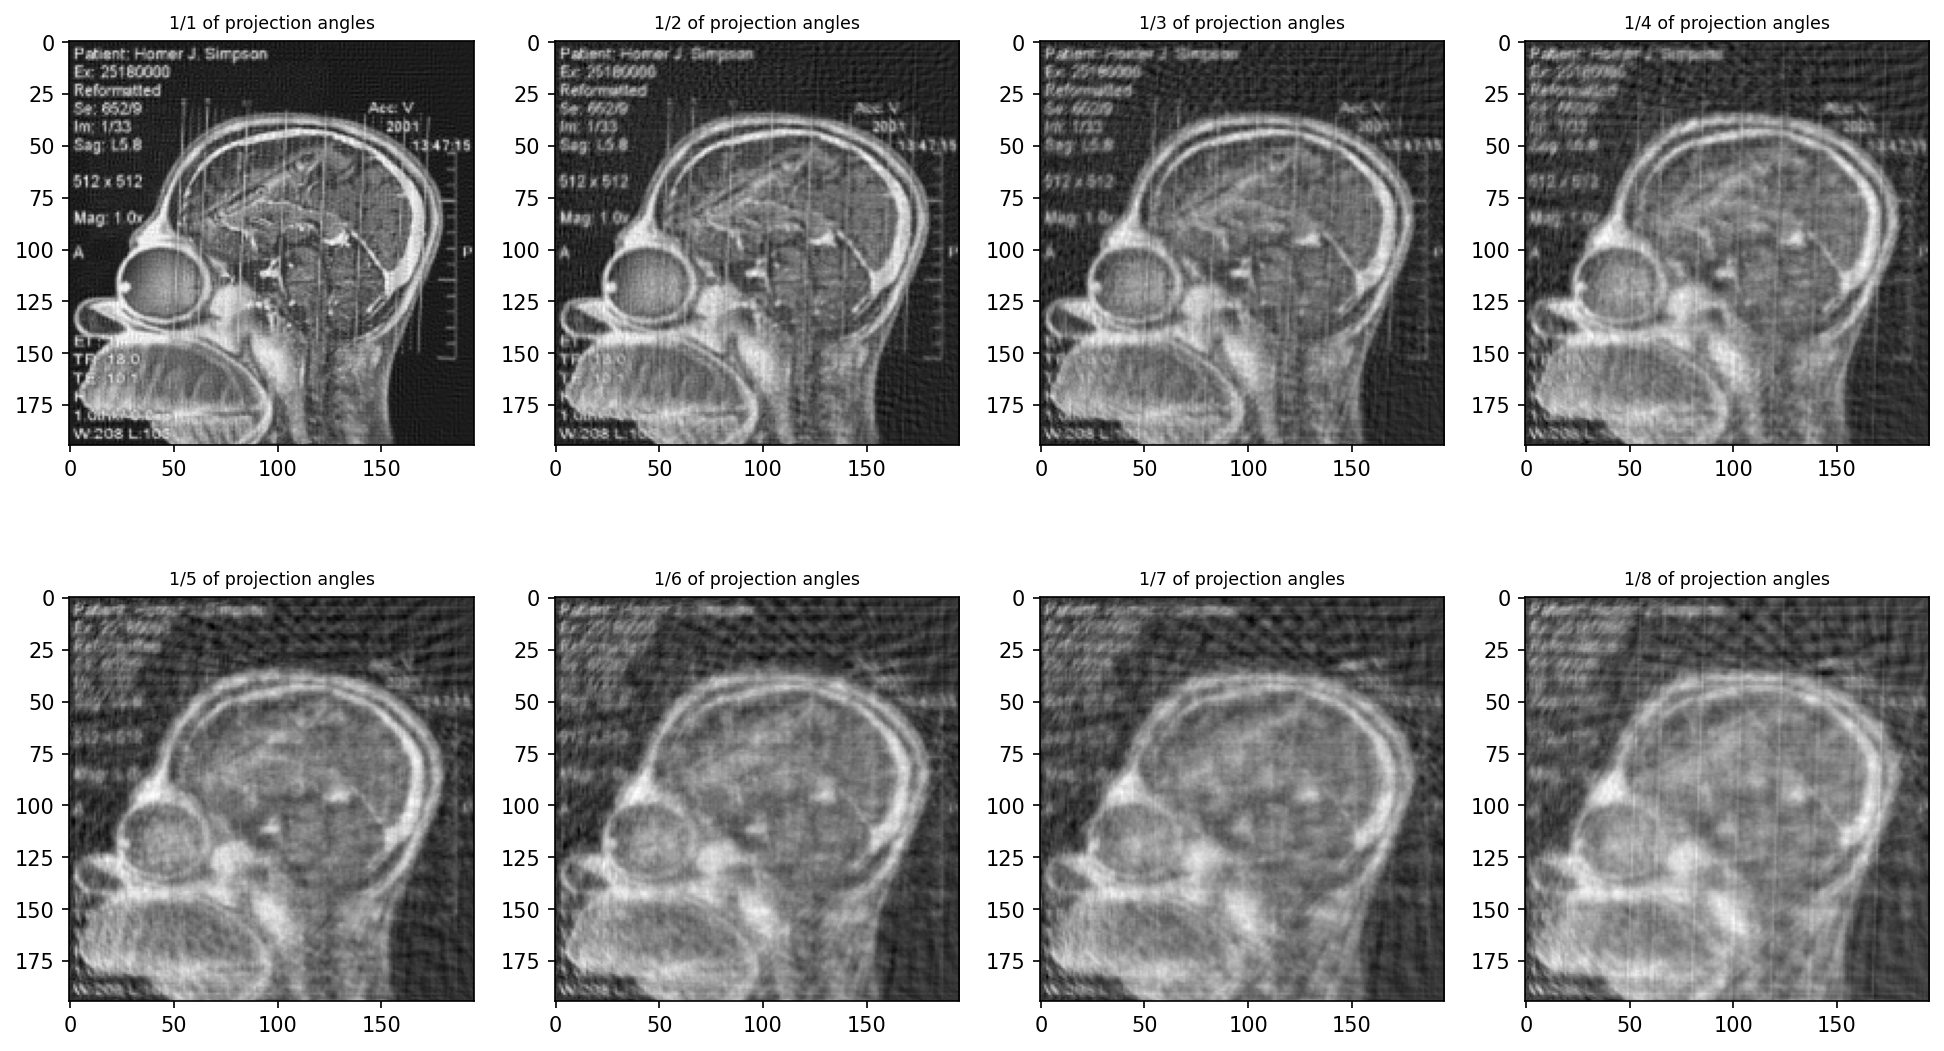

In [18]:
plt.figure(figsize=(16, 9), dpi=150)
for i in range (1, 9):
    mask = create_mask(i, len(alphas_195))
    y_new, alpha_new = reduce_y_alpha(y_195, alphas_195, mask, 275)
    X = construct_X(195, alpha_new, 275)
    X_csc = X.tocsc()
    # only work with tolerance 1e-5 here because otherwise, the procedure would take too long
    beta = linalg.lsqr(X_csc, y_new, atol=1e-5, btol=1e-5)
    mu = np.reshape(beta[0], (195, 195))
    plt.subplot(2, 4, i)
    plt.title(f'1/{i} of projection angles', size='small')
    plt.imshow(mu)

On these plots, one can clearly see, how the quality of the image decreases. In our opionion, one could still reveal the cause of Homer's headache, if one uses every third projection angle. From there on, the structures get too smeared to make further propositions.